# Figure 5 (behavioral experiment)
The goal of this experiment is to test a non-trivial prediction of the conditional leak model, that is, visual motion withe net-zero displacement would still degrade the optic flow memory.

Fish experienced 3-s open-loop motion (*priming*), followed by a wait period of variable duraitons, and a 10-s closed-loop motion (*probe*).

During the wait period, the visual pattern either stayed stationary, or oscillated back and forth with frequency of 0.5 Hz and the peak amplitude of 5 mm/s.

In [1]:
# Import packages
import numpy as np
import os
from bouter import EmbeddedExperiment
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon, binned_statistic
import colorcet as cc
from tqdm import tqdm
from homr_util import *

In [2]:
# Tweaking matplotlib 
set_rcParams()

In [3]:
# Find data
data_dir = './data/fig5_02'
fish_list = os.listdir(data_dir)
n_fish = len(fish_list)
print('total',n_fish,'fish')

total 34 fish


## Analysis
- Loop around the fish directories, load behavioral data (i.e. swim effort)
- Down sample data to 20 Hz
- Cut out snippet around each stimulus epoch, sort by epoch type

In [4]:
bin_dt = 1/20 # downsample to 20 Hz

all_fvtraces = [] # we only quantify the fish swim effort

# align binning at the probe onset
time_bin = np.arange(-18,10,bin_dt)
binned_t = (time_bin[1:]+time_bin[:-1])/2

# loop through fish
for fish in tqdm(fish_list):
    
    # load data
    exp = EmbeddedExperiment(data_dir + '/' + fish)
    slog = exp['stimulus']['log']
    
    ## time trace extraction
    # timestamp (60 Hz-ish)
    t_s = exp.stimulus_log['t'].to_numpy()
    # fish velocity
    fv = exp.stimulus_log['WavyWaiting_fish_vel'].to_numpy() * exp.stimulus_log['WavyWaiting_fish_swimming'].to_numpy() * exp.stimulus_log['WavyWaiting_vigor_gain'].to_numpy()
    
    fvtraces  = [[] for i in range(12)]
    
    # go through epochs
    for epoch in slog:
        
        # first, figure out which type of epoch this was
        # Wave OFF/ON x Direction x Duration
        pre_dir = epoch['vel_pre']>0
        wait_dur = epoch['t_probe_start']-8
        is_wave = epoch['wave_amplitude']>0
        epoch_id = 6*is_wave + 3*pre_dir + int((wait_dur-2)/4)
        
        # calculate time stamps
        duration = epoch['duration']
        t_end = epoch['t_stop']
        t_start = t_end - duration
        
        # cut out snippets (trust end more than start)
        this_epoch_ind = np.logical_and(t_s>t_start, t_s<=t_end)
        this_t = t_s[this_epoch_ind]
        this_t = this_t - t_start - wait_dur - 8 
        
        # do binning
        binned_fv = binned_statistic(this_t, fv[this_epoch_ind], bins=time_bin)[0]
        
        # saving
        fvtraces[epoch_id].append(binned_fv)
    
    all_fvtraces.append(fvtraces)

100%|████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.06it/s]


In [5]:
# Conversion to numpy array 
all_fvtraces = np.asarray(all_fvtraces)

In [6]:
# average traces over fish and trial
trial_mean_fvtraces = np.nanmean(all_fvtraces, axis=2)
fish_mean_fvtraces = np.mean(trial_mean_fvtraces, axis=0)
fish_sem_fvtraces = np.std(trial_mean_fvtraces, axis=0)/np.sqrt(n_fish)

# average over time
mean_probe_fv = np.nanmean(all_fvtraces[:, :, :, (binned_t>0) * (binned_t<10)], axis=3)

# over trials
fish_mean_probe_fv = np.mean(mean_probe_fv, axis=2)

# over fish
group_mean_pfv = np.mean(fish_mean_probe_fv, axis=0)
group_sem_pfv = np.std(fish_mean_probe_fv, axis=0) / np.sqrt(n_fish)

# calculate by-direction difference (normalized by mean fv over all conditions)
directional_fv_diff = (fish_mean_probe_fv[:, (3,4,5,9,10,11)] - fish_mean_probe_fv[:, (0,1,2,6,7,8)]) / np.mean(fish_mean_probe_fv, axis=1)[:, None] 

# calculate mean and sem across fish
mean_dfvd = np.mean(directional_fv_diff, axis=0)
sem_dfvd = np.std(directional_fv_diff, axis=0)/np.sqrt(n_fish)

C:\Users\ryosuke\AppData\Local\Temp\ipykernel_8312\1721673972.py:2: RuntimeWarning: Mean of empty slice
  trial_mean_fvtraces = np.nanmean(all_fvtraces, axis=2)


## Panels
### Fig. 5HI (Time-averaged probe swim, by conditions & fractional difference by priming directions)

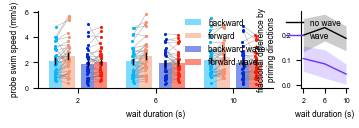

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(4,1), width_ratios=(5,1))

# mean data for each condition
ax[0].bar(np.arange(3)*6, group_mean_pfv[0:3], width=1, color=cc.cm.CET_D11(0.0), alpha=0.5, label='backward')
ax[0].bar(np.arange(3)*6+1, group_mean_pfv[3:6], width=1, color=cc.cm.CET_D11(1.0), alpha=0.5, label='forward')
ax[0].bar(np.arange(3)*6+2.5, group_mean_pfv[6:9], width=1, color=cc.cm.CET_D8(0.0), alpha=0.5, label='backward wave')
ax[0].bar(np.arange(3)*6+3.5, group_mean_pfv[9:12], width=1, color=cc.cm.CET_D8(1.0), alpha=0.5, label='forward wave')

# plot individual fish data
for i in range(3):
    jitter = (np.random.rand(n_fish)-0.5) * 0.1
    
    ax[0].plot(np.vstack((jitter+i*6, jitter+i*6+1)), fish_mean_probe_fv[:, (i,i+3)].T, color=(0.5,0.5,0.5), alpha=0.5, lw=0.5)
    ax[0].plot(np.vstack((jitter+i*6+2.5, jitter+i*6+3.5)), fish_mean_probe_fv[:, (i+6,i+9)].T, color=(0.5,0.5,0.5), alpha=0.5, lw=0.5)
    
    ax[0].scatter(jitter+6*i, fish_mean_probe_fv[:, i], s=5, color=cc.cm.CET_D11(0.0), zorder=3)
    ax[0].scatter(jitter+6*i+1, fish_mean_probe_fv[:, i+3], s=5, color=cc.cm.CET_D11(1.0), zorder=3)
    ax[0].scatter(jitter+6*i+2.5, fish_mean_probe_fv[:, i+6], s=5, color=cc.cm.CET_D8(0.0), zorder=3)
    ax[0].scatter(jitter+6*i+3.5, fish_mean_probe_fv[:, i+9], s=5, color=cc.cm.CET_D8(1.0), zorder=3)
    
    # error bar
    ax[0].plot((i*6, i*6), (group_mean_pfv[i]-group_sem_pfv[i], group_mean_pfv[i]+group_sem_pfv[i]), 'k-', lw=1, zorder=5)
    ax[0].plot((i*6+1, i*6+1), (group_mean_pfv[i+3]-group_sem_pfv[i+3], group_mean_pfv[i+3]+group_sem_pfv[i+3]), 'k-', lw=1, zorder=5)
    ax[0].plot((i*6+2.5, i*6+2.5), (group_mean_pfv[i+6]-group_sem_pfv[i+6], group_mean_pfv[i+6]+group_sem_pfv[i+6]), 'k-', lw=1, zorder=5)
    ax[0].plot((i*6+3.5, i*6+3.5), (group_mean_pfv[i+9]-group_sem_pfv[i+9], group_mean_pfv[i+9]+group_sem_pfv[i+9]), 'k-', lw=1, zorder=5)
    
ax[0].set_ylabel('probe swim speed (mm/s)')
ax[0].set_xticks(np.arange(3)*6+1.75)
ax[0].set_xticklabels((2,6,10))

# Plot fractional differences
ax[1].fill_between((2,6,10), mean_dfvd[:3]-sem_dfvd[:3], mean_dfvd[:3]+sem_dfvd[:3], alpha=0.2, color=(0,0,0))
ax[1].fill_between((2,6,10), mean_dfvd[3:]-sem_dfvd[3:], mean_dfvd[3:]+sem_dfvd[3:], alpha=0.2, color=(0.4, 0.2, 1.0))
ax[1].plot((2,6,10), mean_dfvd[:3], color=(0,0,0), label='no wave')
ax[1].plot((2,6,10), mean_dfvd[3:], color=(0.4, 0.2, 1.0), label='wave')
ax[1].set_xticks((2,6,10))
ax[1].set_ylabel('fractional difference by\npriming directions')

for axx in ax:
    axx.legend()
    axx.set_xlabel('wait duration (s)')
    toggle_spines(axx, 0, 1, 0, 1)
    
plt.savefig('./svgs/Fig5HI.svg', format='svg')
plt.show()

In [8]:
# Run stats
for i in range(3):
    print('wait duration {0}s, wave vs. no wave wilcoxon p={1:0.2}'.format(i*4+2, wilcoxon(directional_fv_diff[:, i], directional_fv_diff[:, i+3])[1]))

wait duration 2s, wave vs. no wave wilcoxon p=0.26
wait duration 6s, wave vs. no wave wilcoxon p=0.0091
wait duration 10s, wave vs. no wave wilcoxon p=0.037
